# AMLB Visualizations
This notebook contains code to generate several figures from the paper "AMLB: an AutoML Benchmark" by Gijsbers et al. (2022). As input, it assumes "cleaned logs" which are available at `http://openml-test.win.tue.nl/amlb/*_cleaned.csv` and the `CleanResults` notebook shows how they are constructed from the raw results. This notebook contains code to generate:

 - [Figure 2: CD plots with Nimenyi post-hoc test after imputing missing values with the constant predictor baseline.](#CD-Plots)
 - [Figure 3: Boxplots of framework performance across tasks after scaling the performance values from random forest (-1) to best observed (0)](#Scaled-Results)
 - [Figure 8: Time spent during search.](#Training-Duration)
 - [latex code for tables 4-9 in the appendix](#Tables)
 
The `orange` dependency for CD plots can be problematic with (some?) Windows setups, but it is possible to install only a few of `orange`'s dependencies to make it work.

*The notebook's code is pretty messy/terrible. PRs to clean it up are welcome, but must be able to produce identical plots.*

In [31]:
import itertools
import math
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

In [32]:
from data_processing import get_print_friendly_name, impute_missing_results, calculate_ranks, add_rescale, is_old
from visualization import FRAMEWORK_TO_COLOR

In [33]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures"

for subfolder in ["CD", "duration", "inference", "performance"]:
    (FIGURE_DIRECTORY / subfolder).mkdir(parents=True, exist_ok=True)

In [34]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})
results = results[results["framework"] != "NaiveAutoML"]
results["framework"] = results["framework"].apply(get_print_friendly_name)

# Scaled Results
Figure 3 in the paper.

In [35]:
def add_horizontal_lines(ax, lines: tuple[tuple[float, str], ...]):
    """Draws horizontal lines specified by (y value, color)-pairs."""
    for y, color in lines:
        ax.axhline(y, color=color)

def box_plot(data, metric=None, ylog=False, title="", ylim=None, figsize=(16, 9), with_framework_names=True, add_counts=None, color_map=None):
    """Creates a boxplot with data["frameworks"] on the x-axis and data[`metric`] on the y-axis
    
    The figure's y-axis may be limited by `ylim` and the number of values outside this limit may be shown in the tick labels.
    """
    if add_counts and (add_counts != "outliers" and not isinstance(add_counts, dict)):
        raise ValueError("`add_counts` must be 'outliers' or a dictionary mapping each framework to a number.")
        
    color_map = color_map or FRAMEWORK_TO_COLOR
    color_map = {k: v for k, v in color_map.items() if k in data["framework"].unique() or k=="autosklearn2"}
    
    metric = metric or data.metric.unique()[0]
    if metric.startswith("neg_"):
        pos_metric = metric[len("neg_"):]
        data[pos_metric], metric = -data[metric], pos_metric
        
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    seaborn.boxplot(
        data=data,
        x="framework",
        y=metric,
        order=color_map,
        hue="constraint" if data.constraint.nunique() > 1 else None,
        palette=color_map if data.constraint.nunique() == 1 else None,
        ax=ax,
        fliersize=1,
    )
    
    if ylog:
        ax.set_yscale("log")
        
    ax.set_ylabel(metric, size='xx-large')
    ax.set_xlabel("")
    ax.tick_params(axis='both', which = 'both', labelsize = 18)
    
    if title:
        ax.set_title(title, fontsize=18)
        
    # Dirty hack for displaying outliers, we overlap minor and major tick labels, where
    # minor labels are used to display the number of outliers, and major tick labels may
    # be used to display the framework names.
    constraint = data.constraint.unique()[0]
    smetric = data.metric.unique()[0]
    frameworks = color_map.keys()
    frameworks = [
        f"{fw if with_framework_names else ''}*" if is_old(fw, constraint, smetric) else fw 
        for fw in frameworks
    ]
    if add_counts:
        # There will be minor tick labels displayed for outliers,
        # to avoid rendering on top of each other, we offset the label location
        # with a dirty hack of using leading spaces :-) 
        frameworks = [f"   {fw}" for fw in frameworks]
    ax.tick_params(axis="x", which="major", rotation=-90)
    ax.set_xticks(*zip(*enumerate(frameworks)))
    
    if ylim:  
        ax.set_ylim(ylim)
        if add_counts != "outliers":
            print("Warning! Ylim is set but outliers are not reported.")
    
    counts = []
    if add_counts:
        if add_counts == "outliers":
            add_counts = {}
            for framework in color_map:
                framework_outliers = data[(data["framework"] == framework) & (data[metric] < ylim[0])]
                add_counts[framework] = f"{len(framework_outliers)}"

        # We need to offset the minor tick labels, otherwise they won't render.
        ax.set_xticks(
            ticks=[i-0.01 for i in range(len(color_map))],
            labels=[f"[{add_counts.get(f, 'x')}]" for f in color_map], 
            minor=True
        )
        
    return fig, ax

generating box-rescaled-multiclass-classification-1h8c_gp3-constantpredictor.pdf
generating box-rescaled-binary-classification-1h8c_gp3-constantpredictor.pdf
generating box-rescaled-regression-1h8c_gp3-constantpredictor.pdf
generating box-rescaled-multiclass-classification-4h8c_gp3-constantpredictor.pdf
generating box-rescaled-binary-classification-4h8c_gp3-constantpredictor.pdf
generating box-rescaled-regression-4h8c_gp3-constantpredictor.pdf


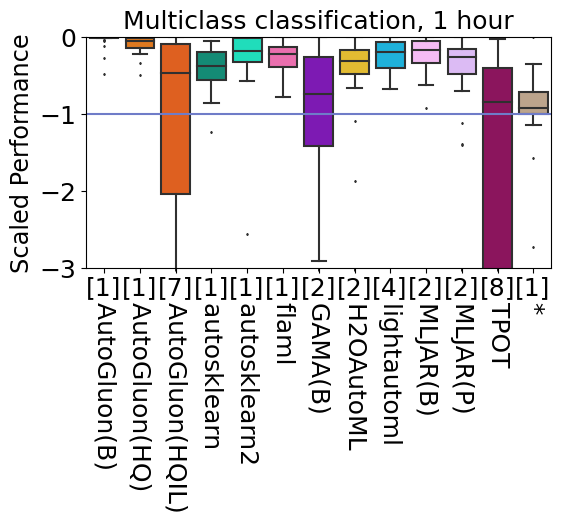

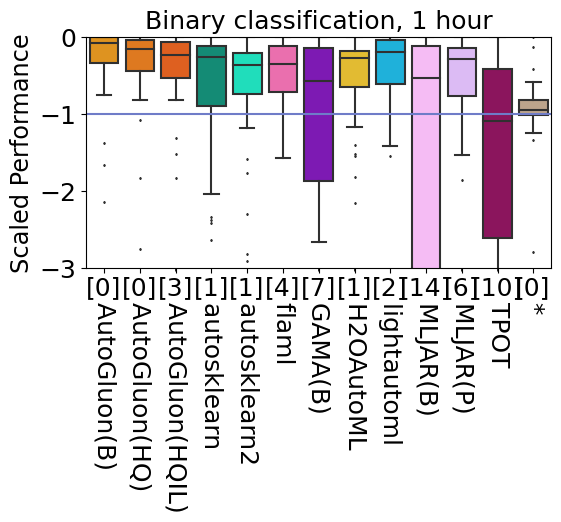

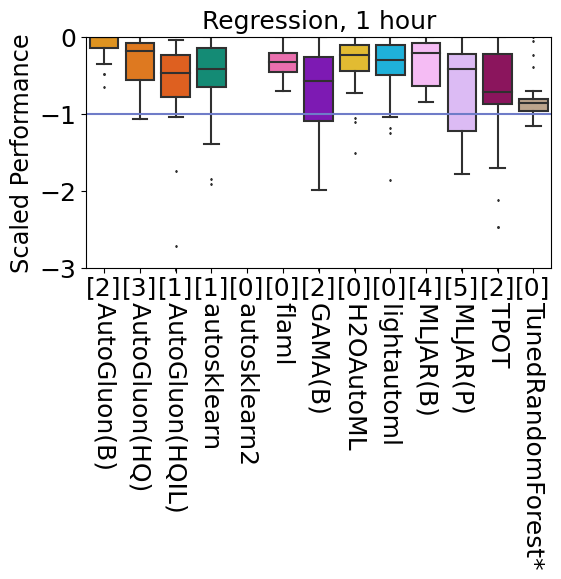

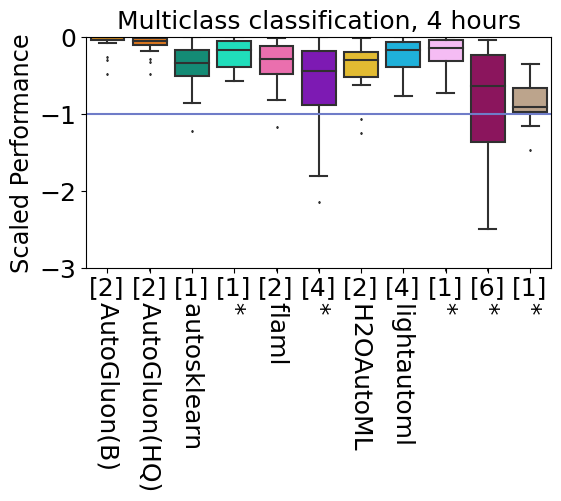

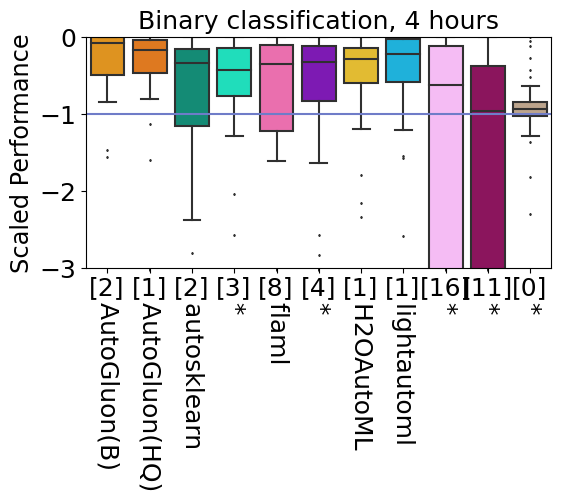

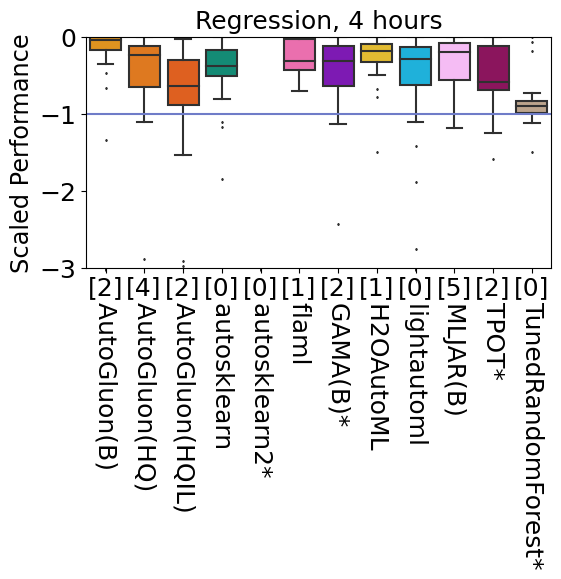

In [30]:
from matplotlib.backends.backend_pdf import PdfPages

for constraint, metric in itertools.product(results.constraint.unique(), results.metric.unique()):
    data = results[(results["metric"] == metric) & (results["constraint"] == constraint)]
    data = impute_missing_results(data, with_results_from="constantpredictor")
    
    data = data[["framework", "task", "constraint", "metric", "result"]].groupby(["framework", "task", "constraint", "metric"], as_index=False).mean()
    data = add_rescale(data, lower="RandomForest")
    data["scaled"] = -data["scaled"]
    data = data[data["framework"] != "RandomForest"]  # Not interesting as it is -1 by definition

    ttype = {"neg_rmse": "regression", "auc": "binary classification", "neg_logloss": "multiclass classification"}[metric]
    time_budget = get_print_friendly_name(constraint)
    filename = f"box-rescaled-{ttype}-{constraint}-constantpredictor.pdf".replace(" ", "-")
    print("generating", filename)
    
    periwinkle_blue = "#6f7cc8"
    fig, ax = box_plot(
        data,
        metric="scaled", 
        title=f"{ttype.capitalize()}, {time_budget}", 
        ylim=[-3, 0],
        figsize=(6, 3),
        with_framework_names=(ttype=="regression"),
        add_counts="outliers"
    )
    ax.set_ylabel("Scaled Performance")
    add_horizontal_lines(ax, ((-1, periwinkle_blue),))
    

    with PdfPages(FIGURE_DIRECTORY / "performance" / filename) as f:
        f.savefig(fig, bbox_inches="tight")

# Inference vs Performance

mean rescaled result vs median inference speed row/s at 10k and at 1

In [57]:
def calculate_pareto(xs, ys) -> list[tuple[float, float]]:
    pairs = list(zip(xs, ys))
    return [
        (x, y)
        for x, y in pairs
        if not any((x2>=x and y2 >=y) and (x!=x2 or y!=y2) for x2, y2 in pairs)
    ]

def plot_pareto(data, x, y, ax, color="#cccccc"):
    pareto = sorted(calculate_pareto(data[x], data[y]))
    for opt, next_opt in zip(pareto, pareto[1:]):
        ax.plot([opt[0], opt[0], next_opt[0]], [opt[1],next_opt[1], next_opt[1]], color=color, zorder=0)
        
    

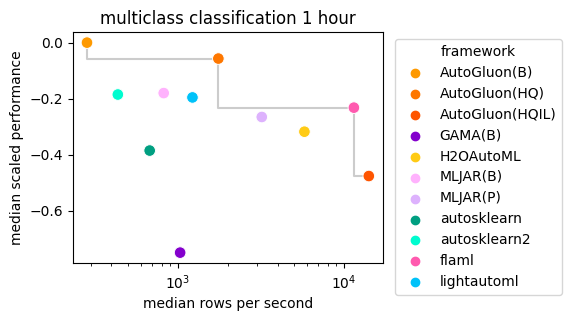

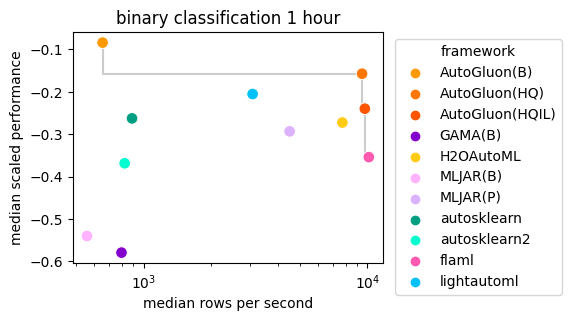

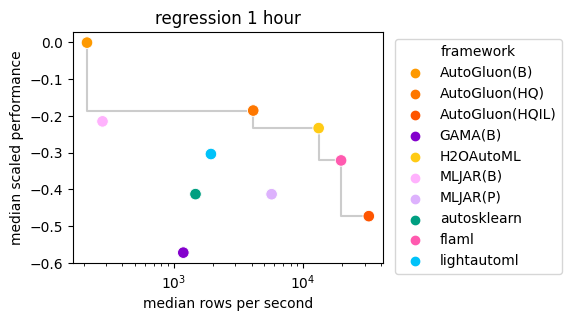

In [70]:
for constraint, metric in itertools.product(["1h8c_gp3"], results["metric"].unique()):    
    time_budget = get_print_friendly_name(constraint)
    ttype = {"neg_rmse": "regression", "auc": "binary classification", "neg_logloss": "multiclass classification"}[metric]
    exclude = ["constantpredictor", "RandomForest", "TunedRandomForest", "TPOT", "NaiveAutoML"]
    if ttype == "regression":
        exclude += ["autosklearn2"]
    
    data = results[(results["constraint"] == constraint) & (results["metric"] == metric)]
    data = impute_missing_results(data, with_results_from="constantpredictor")
    
    data = data[["framework", "task", "constraint", "metric", "result", "infer_batch_size_file_10000"]].groupby(["framework", "task", "constraint", "metric"], as_index=False).mean()
    data = add_rescale(data, lower="RandomForest")    
    data = data[~data["framework"].isin(exclude)]
    data["scaled"] = -data["scaled"]
    data = data.groupby(["framework", "constraint", "metric"])[["infer_batch_size_file_10000", "scaled"]].median()

    
    data["row_per_s"] = 10_000. / data["infer_batch_size_file_10000"]
    color_map = {k: v for k, v in FRAMEWORK_TO_COLOR.items() if k not in exclude}

    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax = seaborn.scatterplot(
        data, 
        x="row_per_s", 
        y="scaled", 
        hue="framework",
        palette=color_map,
        s=70,  # marker size
        ax=ax,
    )
    plot_pareto(data, x="row_per_s", y="scaled", ax=ax)
    ax.set_title(f"{ttype} {time_budget}")
    ax.set_xscale('log')
    ax.set_xlabel('median rows per second')
    ax.set_ylabel('median scaled performance')
    seaborn.move_legend(ax, "upper right", bbox_to_anchor=(1.6, 1))

    with PdfPages(FIGURE_DIRECTORY / "inference" / f"{ttype.replace(' ','-')}_{constraint}.pdf") as f:
        f.savefig(fig, bbox_inches="tight")



## Correlation between inference time measurement and predict time measurement after normalization

In [9]:
raise RuntimeError("Stop `restart kernel and run all` here, as cells below are not up to date")

RuntimeError: Stop `restart kernel and run all` here, as cells below are not up to date

In [ ]:
import openml
regression_suite = openml.study.get_suite(269)
datasets_reg = openml.datasets.list_datasets(regression_suite.data, output_format="dataframe")
datasets_reg = datasets_reg[["name", "NumberOfInstances", "NumberOfFeatures"]]

classification_suite = openml.study.get_suite(271)
datasets_clf = openml.datasets.list_datasets(classification_suite.data, output_format="dataframe")
datasets_clf = datasets_clf[["name", "NumberOfInstances", "NumberOfFeatures"]]

datasets = pd.concat([datasets_reg, datasets_clf])
results = pd.read_csv("../intermediate-results/results.20230627.3.csv")

In [ ]:
meta_regression = pd.merge(results, datasets, left_on="task", right_on="name")
meta_regression["predict_by_row"] = meta_regression["predict_duration"] / meta_regression["NumberOfInstances"]
meta_regression["predict_by_cell"] = meta_regression["predict_duration"] / (meta_regression["NumberOfInstances"] * meta_regression["NumberOfFeatures"])

In [ ]:
meta_regression = meta_regression[~meta_regression["predict_duration"].isna()]
meta_regression = meta_regression[~meta_regression["infer_batch_size_file_10000"].isna()]

In [ ]:
import scipy.stats
scipy.stats.pearsonr(meta_regression["infer_batch_size_file_10000"], meta_regression[ "predict_by_row"])

In [ ]:
meta_regression[["infer_batch_size_file_10000", "predict_by_row"]].corr()

# Tables - Ignore below (or toy around with it... I didn't update it)
Generating tables 4-9 of the appendix.

In [ ]:
metric = "logloss"
constraint = "1h8c_gp3"
map_for_caption = {"auc": "binary classification (in AUC)", "1h8c_gp3": "one hour", "4h8c_gp3": "four hour", "logloss": "multiclass classification (log loss)"}

In [ ]:
data = get_results(metric, constraint)
data = data[~data.framework.isin(["constantpredictor", "mlr3automl", "RandomForest", "TunedRandomForest"])]
data.framework.unique()

In [ ]:
summary = data.groupby(["framework", "task", "id"], as_index=False).agg({"result": ["mean", "std", "count"]})
summary["fails"] = 10 - summary[("result", "count")]

In [ ]:
def combine_as_separate(tuple_):
    mean, std, fails = tuple_
    if fails == 10:
        return "[10]"
    else:
        return f"{mean:.2f}" + (f"[{int(fails)}]" if fails > 0 else "")
    
def combine_as_supertext(tuple_):
    mean, std, fails = tuple_
    if fails == 10:
        return "-$\hspace{0.4em}$"
    else:# if fails > 0:
        backslash = "\hspace{0.4em}"
        return f"{mean:.3f}({std:.3f})$^{{{int(fails) if int(fails) != 0 else backslash}}}$"

In [ ]:
summary["display"] = summary[[("result", "mean"), ("result", "std"), ("fails", "")]].agg(combine_as_supertext, axis=1)
summary = summary[[("framework", ""), ("task", ""), ("id", ""), ("display", "")]]

In [ ]:
summary.columns = ["framework", "task", "id", "display"]
summary["id"] = summary["id"].apply(lambda s: s.split("/")[-1])
summary["task"] = summary["task"].apply(lambda s: s if len(s) < 10 else (s[:8] + "..."))
summary.sort_values("framework", inplace=True, key=lambda s: s.str.lower().sort_values())

In [ ]:
tab = summary.pivot(index=["id", "task"], columns="framework", values="display")
tab = tab[[c for c in sorted(tab.columns, key=lambda s: s.lower())]]

In [ ]:
tab.head()

In [ ]:
tex = tab.style.to_latex().replace("_", r"\_")

# the headers will be too wide to fit a page, we rotate them:
old_header, body = tex.splitlines()[:3], tex.splitlines()[3:]
new_header = [
    r"\footnotesize",
    r"\begin{table}",
    r"\begin{tabular}{rl" + "r" * len(tab.columns) + "}",
    r"\toprule",
    " & framework" + "".join([f"& \\rotatebox[origin=c]{{-90}}{{{framework}}}" for framework in tab.columns]) + r"\\",
    " task id & task name " + "& " * len(tab.columns) + r"\\",
    r"\midrule",
]
*body, footer = body
caption = f"\\caption{{Results for {map_for_caption[metric]} on a {map_for_caption[constraint]} budget.}}"
label = f"\\label{{tab:{metric}-{constraint}}}"
footer = [r"\bottomrule", footer, caption, label, r"\end{table}"]

with open("mytable.tex", "w") as fh:
    fh.write("\n".join(new_header + body + footer))

In [ ]:
map_for_caption = {
    "auc": "binary classification (in AUC)", "neg_logloss": "multiclass classification (in logloss)", "neg_rmse": "regression (in RMSE)",
    "1h8c_gp3": "one hour", "4h8c_gp3": "four hour"
}

def generate_table_for(metric, constraint, filename="mytable.tex", exclude=["constantpredictor", "mlr3automl"]): # "RandomForest", "TunedRandomForest"
    data = get_results(metric, constraint)
    data = data[~data.framework.isin(exclude)]
    if metric != "auc":
        data["result"] = -data["result"]
    
    summary = data.groupby(["framework", "task", "id"], as_index=False).agg({"result": ["mean", "std", "count"]})
    summary["fails"] = 10 - summary[("result", "count")]
    
    def combine_as_supertext(tuple_):
        mean, std, fails = tuple_
        if fails == 10:
            return "-"
        elif fails > 0:
            return f"${mean:.2f}^{{{int(fails)}}}$"
        else:
            return f"{mean:.2f}"

    summary["display"] = summary[[("result", "mean"), ("result", "std"), ("fails", "")]].agg(combine_as_supertext, axis=1)
    summary = summary[[("framework", ""), ("task", ""), ("id", ""), ("display", "")]]
    summary.columns = ["framework", "task", "id", "display"]
    summary["id"] = summary["id"].apply(lambda s: s.split("/")[-1])
    summary["task"] = summary["task"].apply(lambda s: s if len(s) < 10 else (s[:8] + "..."))
    summary.sort_values("framework", inplace=True, key=lambda s: s.str.lower().sort_values())
    
    tab = summary.pivot(index=["id", "task"], columns="framework", values="display")
    tab = tab[[c for c in sorted(tab.columns, key=lambda s: s.lower())]]
    
    tex = tab.style.to_latex().replace("_", r"\_")

    # the headers will be too wide to fit a page, we rotate them:
    old_header, body = tex.splitlines()[:3], tex.splitlines()[3:]
    new_header = [
        r"\footnotesize",
        r"\begin{table}",
        r"\begin{tabular}{rl" + "r" * len(tab.columns) + "}",
        r"\toprule",
        " & framework" + "".join([f"& \\rotatebox[origin=c]{{-90}}{{{framework}}}" for framework in tab.columns]) + r"\\",
        " task id & task name " + "& " * len(tab.columns) + r"\\",
        r"\midrule",
    ]
    *body, footer = body
    caption = f"\\caption{{Results for {map_for_caption[metric]} on a {map_for_caption[constraint]} budget.}}"
    label = f"\\label{{tab:{metric}-{constraint}}}"
    footer = [r"\bottomrule", footer, caption, label, r"\end{table}"]

    with open(filename, "w") as fh:
        fh.write("\n".join(new_header + body + footer))

# requires \usepackage{makecell}
for metric in ["auc", "neg_logloss", "neg_rmse"]:
    for constraint in ["1h8c_gp3", "4h8c_gp3"]:
        generate_table_for(metric, constraint, f"{metric}-{constraint}-table.tex")
    

In [ ]:
map_for_caption = {
    "auc": "binary classification (in AUC)", "neg_logloss": "multiclass classification (in logloss)", "neg_rmse": "regression (in RMSE)",
    "1h8c_gp3": "one hour", "4h8c_gp3": "four hour"
}

def generate_sideways_table_for(metric, constraint, filename="mytable.tex", exclude=["constantpredictor", "mlr3automl", "RandomForest", "TunedRandomForest"]): # "RandomForest", "TunedRandomForest"
    data = get_results(metric, constraint)
    data = data[~data.framework.isin(exclude)]
    if metric != "auc":
        data["result"] = -data["result"]
    
    summary = data.groupby(["framework", "task", "id"], as_index=False).agg({"result": ["mean", "std", "count"]})
    summary["fails"] = 10 - summary[("result", "count")]
    
    def combine_as_supertext(tuple_):
        fw, mean, std, fails = tuple_
        std_text = f"({std:.3f})" if metric != "neg_rmse" else f"({std:.2g})"
        if fails == 10:
            return "-$\hspace{0.4em}$"
        else:# if fails > 0:
            backslash = "\hspace{0.4em}"
            if metric != "neg_rmse":
                return f"{mean:.3f}{std_text}$^{{{int(fails) if int(fails) != 0 else backslash}}}$"
            else:
                return f"{mean:.2g}{std_text}$^{{{int(fails) if int(fails) != 0 else backslash}}}$"
    summary["display"] = summary[[("framework", ""), ("result", "mean"), ("result", "std"), ("fails", "")]].agg(combine_as_supertext, axis=1)
    summary = summary[[("framework", ""), ("task", ""), ("id", ""), ("display", "")]]
    summary.columns = ["framework", "task", "id", "display"]
    summary["id"] = summary["id"].apply(lambda s: s.split("/")[-1])
    summary["task"] = summary["task"].apply(lambda s: s.lower() if len(s) < 10 else (s.lower()[:8] + "..."))
    summary.sort_values("framework", inplace=True, key=lambda s: s.str.lower().sort_values())
    
    tab = summary.pivot(index=["id", "task"], columns="framework", values="display")
    tab = tab[[c for c in sorted(tab.columns, key=lambda s: s.lower())]]
    
    tex = tab.style.to_latex().replace("_", r"\_")

    # the headers will be too wide to fit a page, we rotate them:
    old_header, body = tex.splitlines()[:3], tex.splitlines()[3:]
    new_header = [
        r"\footnotesize",
        r"\begin{landscape}",
        r"\begin{table}",
        r"\tiny",
        r"\begin{tabular}{rl" + "r" * len(tab.columns) + "}",
        r"\toprule",
        " & framework" + "".join([f"& {framework}\ \ " for framework in tab.columns]) + r"\\",
        " task id & task name " + "& " * len(tab.columns) + r"\\",
        r"\midrule",
    ]
    *body, footer = body
    caption = f"\\caption{{Results for {map_for_caption[metric]} on a {map_for_caption[constraint]} budget, denoted as \\texttt{{mean}}(\\texttt{{std}})$^{{\\mbox{{\\texttt{{fails}}}}}}$.}}"
    label = f"\\label{{tab:{metric}-{constraint}}}"
    footer = [r"\bottomrule", footer, caption, label, r"\end{table}", r"\end{landscape}",]

    with open(filename, "w") as fh:
        fh.write("\n".join(new_header + body + footer))

# requires \usepackage{makecell}
for metric in ["auc", "neg_logloss", "neg_rmse"]:
    for constraint in ["1h8c_gp3", "4h8c_gp3"]:
        generate_sideways_table_for(metric, constraint, f"{metric}-{constraint}-table.tex")
    

Unused code for win/loss tables, champions:

In [ ]:
data = get_results("all", budget="1h8c_gp3")
data = impute_values(data, strategy="constantpredictor")
data = data[~data.framework.isin(["mlr3automl", "constantpredictor"])]
data = data.groupby(["framework", "task", "constraint"], as_index=False).mean()

In [ ]:
result = data[["framework", "task", "result"]]
cross = result.join(result, how="cross", rsuffix="_other")
cross = cross[(cross["framework"] != cross["framework_other"]) & (cross["task"] == cross["task_other"])]
cross.head()

In [ ]:
def win_and_loss(data):
    best_score = data[["result", "result_other"]].max(axis=1)
    return pd.Series(dict(
        win= sum(data["result"] - data["result_other"] > best_score * 0.001),
        loss= sum(data["result_other"] - data["result"] > best_score * 0.001),
        tie= sum(abs(data["result"] - data["result_other"]) < best_score * 0.001)
    ))
# cross.groupby(["framework", "framework_other"], as_index=False).apply(lambda df: sum(df["result"] > df["result_other"]))

In [ ]:
wins_and_losses = cross.groupby(["framework", "framework_other"], as_index=False).apply(win_and_loss)
wins_and_losses.sample(5)

In [ ]:
wins_and_losses["wl_str"] = wins_and_losses.apply(lambda r: f"{r['win']}/{r['loss']}/{r['tie']}", axis=1)

In [ ]:
win_loss_table = wins_and_losses.pivot(index="framework", columns="framework_other", values="wl_str")
framework_order = sorted(win_loss_table.columns, key=lambda s: s.lower())
win_loss_table[framework_order].loc[framework_order]

In [ ]:
table = win_loss_table[framework_order].loc[framework_order]
tex = table.style.to_latex().replace("_", r"\_").replace("nan", "-")

with open("win_loss_table.tex", "w") as fh:
    fh.write(tex)
    #fh.write("\n".join(new_header + body + footer))

In [ ]:
table = win_loss_table[framework_order].loc[framework_order]
tex = table.style.to_latex().replace("_", r"\_").replace("nan", "-")

# # the headers will be too wide to fit a page, we rotate them:
old_header, body = tex.splitlines()[:3], tex.splitlines()[3:]
new_header = [
    r"\footnotesize",
    r"\begin{landscape}",
    r"\begin{table}",
    r"\tiny",
    r"\begin{tabular}{r" + "r" * len(table.columns) + "}",
    r"\toprule",
    " framework A" + "".join([f"& \\rotatebox[origin=c]{{-90}}{{{framework}}}" for framework in table.columns]) + r"\\",
    #" & \ \ framework B" + "".join([f"& {framework}\ \ " for framework in table.columns]) + r"\\",
    " framework B " + "& " * len(table.columns) + r"\\",
    r"\midrule",
]
*body, footer = body
caption = f"\\caption{{Results of direct comparison between frameworks on a one hour budget across all suites. Each cell denotes the wins, losses, and ties of the row-framework over the column-framework (e.g., AutoGluon(B) wins from autosklearn 78 times). A tie is recorded if the relative difference is smaller than 0.1 percent of the greater score. No statistical tests are used.}}"
label = f"\\label{{tab:head-to-head}}"
footer = [r"\bottomrule", footer, caption, label, r"\end{table}", r"\end{landscape}",]

with open("win_loss_table.tex", "w") as fh:
    fh.write("\n".join(new_header + body + footer))

In [ ]:
data = get_results("all", budget="1h8c_gp3")
data = impute_values(data, strategy="constantpredictor")
data = data[~data.framework.isin(["mlr3automl", "constantpredictor"])]
data = data.groupby(["framework", "task", "constraint"], as_index=False).mean()

In [ ]:
# Find max per task to have a reference point for `champions'
max_per_task = data.groupby(["task"]).max()["result"]
data["max_for_task"] = data["task"].apply(lambda t: max_per_task.loc[t])
data["is_champion"] = abs(data["max_for_task"] - data["result"]) < abs(data["max_for_task"] * 0.001)

In [ ]:
data.groupby("framework").sum()["is_champion"]